In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/IE313/DoAn/Data/WB_WDI_WIDEF.csv')
df.head(5)

Mounted at /content/drive


,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,SEX_LABEL,AGE,AGE_LABEL,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,A,Annual,ABW,Aruba,WB_WDI_AG_CON_FERT_ZS,Fertilizer consumption (kilograms per hectare ...,_T,Total,_T,All age ranges or no breakdown by age,...,3.185000,2.710000,2.485000,1.375000,17.270000,13.195000,15.920000,15.925000,NaN,NaN
1,A,Annual,ABW,Aruba,WB_WDI_AG_LND_AGRI_K2,Agricultural land (sq. km),_T,Total,_T,All age ranges or no breakdown by age,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,NaN,NaN,NaN
2,A,Annual,ABW,Aruba,WB_WDI_AG_LND_AGRI_ZS,Agricultural land (% of land area),_T,Total,_T,All age ranges or no breakdown by age,...,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,NaN,NaN
3,A,Annual,ABW,Aruba,WB_WDI_AG_LND_ARBL_HA,Arable land (hectares),_T,Total,_T,All age ranges or no breakdown by age,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,NaN,NaN,NaN
4,A,Annual,ABW,Aruba,WB_WDI_AG_LND_ARBL_HA_PC,Arable land (hectares per person),_T,Total,_T,All age ranges or no breakdown by age,...,0.018535,0.018395,0.018393,0.018364,0.018315,0.018418,0.018570,NaN,NaN,NaN


In [2]:
df.shape

(287507, 91)

# Clean Dataset

In [3]:
years = [str(y) for y in range(2018, 2023)]
df_years = df[["INDICATOR", "INDICATOR_LABEL", "REF_AREA_LABEL"] + years]

# Hàm tính coverage
def calc_coverage(group):
  total_countries = group["REF_AREA_LABEL"].nunique()

  valid_countries = group.drop(columns=["INDICATOR", "INDICATOR_LABEL", "REF_AREA_LABEL"])\
                          .notna().groupby(group["REF_AREA_LABEL"]).any().sum()

  count_countries = valid_countries.max()
  return count_countries / total_countries

# Tính coverage cho từng chỉ số
coverage = (
    df_years.groupby(["INDICATOR","INDICATOR_LABEL"])
    .apply(lambda g: calc_coverage(g))
    .reset_index(name="coverage")
)

# Lọc các chỉ số có coverage > 70%
core_candidates = coverage[coverage["coverage"] >= 0.7].sort_values("coverage", ascending=False)

/tmp/ipython-input-3865712914.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calc_coverage(g))


In [4]:
df_years.head()

,INDICATOR,INDICATOR_LABEL,REF_AREA_LABEL,2018,2019,2020,2021,2022
0,WB_WDI_AG_CON_FERT_ZS,Fertilizer consumption (kilograms per hectare ...,Aruba,1.375000,17.270000,13.195000,15.920000,15.925000
1,WB_WDI_AG_LND_AGRI_K2,Agricultural land (sq. km),Aruba,20.000000,20.000000,20.000000,20.000000,NaN
2,WB_WDI_AG_LND_AGRI_ZS,Agricultural land (% of land area),Aruba,11.111111,11.111111,11.111111,11.111111,11.111111
3,WB_WDI_AG_LND_ARBL_HA,Arable land (hectares),Aruba,2000.000000,2000.000000,2000.000000,2000.000000,NaN
4,WB_WDI_AG_LND_ARBL_HA_PC,Arable land (hectares per person),Aruba,0.018364,0.018315,0.018418,0.018570,NaN


In [5]:
df_years.shape

(287507, 8)

In [6]:
# @title Tính trung bình 5 năm cho các chỉ số
year_cols = ['2018', '2019', '2020', '2021', '2022']
df['mean_value'] = df_years[year_cols].mean(axis=1)
df_mean = df[['REF_AREA_LABEL', 'INDICATOR_LABEL', 'mean_value']].dropna(subset=['mean_value'])
df_mean.head()

,REF_AREA_LABEL,INDICATOR_LABEL,mean_value
0,Aruba,Fertilizer consumption (kilograms per hectare ...,12.737000
1,Aruba,Agricultural land (sq. km),20.000000
2,Aruba,Agricultural land (% of land area),11.111111
3,Aruba,Arable land (hectares),2000.000000
4,Aruba,Arable land (hectares per person),0.018417


In [7]:
# @title Chuyển bộ dữ liệu từ hàng sang cột
df_pivot = (df_mean.pivot(index='REF_AREA_LABEL', columns='INDICATOR_LABEL', values='mean_value').reset_index())
df_pivot.columns.name = None
df_pivot.head()

,REF_AREA_LABEL,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",...,Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,67.700000,33.760000,16.480000,83.820000,94.360000,92.920000,98.640000,9.65,4.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.152254,500.0
1,Africa Eastern and Southern,NaN,20.816076,8.742633,40.287994,46.127355,30.766278,73.891697,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.367302,NaN
2,Africa Western and Central,38.667591,18.687423,5.187568,36.171359,52.907746,26.119644,83.977805,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,81.800000,82.800000,66.220000,93.800000,100.000000,100.000000,100.000000,44.17,45.69,...,6.8,1.8,0.8,3.7,5.2,0.9,1.4,11.8,28.347477,100.0
4,Algeria,47.000000,99.700000,98.860000,99.920000,99.720000,99.060000,99.920000,44.10,31.19,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.8,47.601629,500.0


In [8]:
df_pivot.shape

(265, 1381)

In [9]:
# @title Chọn ra các quốc gia được liên hiệp quốc công nhận
# Các quốc gia được liên hợp quốc công nhận
countries = [
    "Afghanistan","Albania","Algeria","Andorra","Angola","Antigua and Barbuda","Argentina","Armenia","Australia","Austria",
    "Azerbaijan","Bahamas, The","Bahrain","Bangladesh","Barbados","Belarus","Belgium","Belize","Benin","Bhutan",
    "Bolivia","Bosnia and Herzegovina","Botswana","Brazil","Brunei Darussalam","Bulgaria","Burkina Faso","Burundi","Cabo Verde","Cambodia",
    "Cameroon","Canada","Central African Republic","Chad","Chile","China","Colombia","Comoros","Congo, Dem. Rep.","Congo, Rep.",
    "Costa Rica","Cote d'Ivoire","Croatia","Cuba","Cyprus","Czechia","Denmark","Djibouti","Dominica","Dominican Republic",
    "Ecuador","Egypt, Arab Rep.","El Salvador","Equatorial Guinea","Eritrea","Estonia","Eswatini","Ethiopia","Fiji","Finland",
    "France","Gabon","Gambia, The","Georgia","Germany","Ghana","Greece","Grenada","Guatemala","Guinea",
    "Guinea-Bissau","Guyana","Haiti","Honduras","Hungary","Iceland","India","Indonesia","Iran, Islamic Rep.","Iraq",
    "Ireland","Israel","Italy","Jamaica","Japan","Jordan","Kazakhstan","Kenya","Kiribati","Korea, Dem. People’s Rep.",
    "Korea, Rep.","Kuwait","Kyrgyz Republic","Lao PDR","Latvia","Lebanon","Lesotho","Liberia","Libya","Liechtenstein",
    "Lithuania","Luxembourg","Madagascar","Malawi","Malaysia","Maldives","Mali","Malta","Marshall Islands","Mauritania",
    "Mauritius","Mexico","Micronesia, Fed. Sts.","Moldova","Monaco","Mongolia","Montenegro","Morocco","Mozambique","Myanmar",
    "Namibia","Nauru","Nepal","Netherlands","New Zealand","Nicaragua","Niger","Nigeria","North Macedonia","Norway",
    "Oman","Pakistan","Palau","Panama","Papua New Guinea","Paraguay","Peru","Philippines","Poland","Portugal",
    "Qatar","Romania","Russian Federation","Rwanda","Samoa","San Marino","Sao Tome and Principe","Saudi Arabia","Senegal","Serbia",
    "Seychelles","Sierra Leone","Singapore","Slovak Republic","Slovenia","Solomon Islands","Somalia","South Africa","South Sudan","Spain",
    "Sri Lanka","St. Kitts and Nevis","St. Lucia","St. Vincent and the Grenadines","Sudan","Suriname","Sweden","Switzerland","Syrian Arab Republic","Tajikistan",
    "Tanzania","Thailand","Timor-Leste","Togo","Tonga","Trinidad and Tobago","Tunisia","Turkey","Turkmenistan","Tuvalu",
    "Uganda","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay","Uzbekistan","Vanuatu","Venezuela, RB","Viet Nam",
    "West Bank and Gaza","Yemen, Rep.","Zambia","Zimbabwe"
]

df_countries = df_pivot[df_pivot['REF_AREA_LABEL'].isin(countries)]
df_countries.head()

,REF_AREA_LABEL,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",...,Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,67.7,33.76,16.48,83.82,94.36,92.92,98.64,9.65,4.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.152254,500.0
3,Albania,81.8,82.80,66.22,93.80,100.00,100.00,100.00,44.17,45.69,...,6.8,1.8,0.8,3.7,5.2,0.9,1.4,11.8,28.347477,100.0
4,Algeria,47.0,99.70,98.86,99.92,99.72,99.06,99.92,44.10,31.19,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.8,47.601629,500.0
6,Andorra,NaN,100.00,100.00,100.00,100.00,100.00,100.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Angola,NaN,49.42,8.24,76.46,46.92,7.30,72.46,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.445042,4900.0


In [10]:
df_countries.shape

(192, 1381)

In [11]:
# @title Chọn ra các chỉ số tốt nhất phù hợp với 17 tiêu chí SDGs
# Các chỉ số có thể lấy
potential_indicators = {
    "SDG 1 (Poverty)": ["Poverty headcount ratio at $2.15", "Poverty headcount ratio at $3.65", "Poverty gap"],
    "SDG 2 (Hunger)": ["Prevalence of undernourishment", "Food insecurity"],
    "SDG 3 (Health)": ["Life expectancy at birth, total", "Mortality rate, under-5", "Maternal mortality ratio"],
    "SDG 4 (Education)": ["Completion rate, lower secondary", "Literacy rate, adult", "School enrollment, secondary"],
    "SDG 5 (Gender)": ["Proportion of seats held by women in national parliaments", "Labor force participation rate, female"],
    "SDG 6 (Water)": ["People using at least basic drinking water services", "People using at least basic sanitation services"],
    "SDG 7 (Energy)": ["Access to electricity", "Renewable energy consumption"],
    "SDG 8 (Work/Growth)": ["GDP per capita (constant 2015", "Unemployment, total (% of total labor force)"],
    "SDG 9 (Infrastructure)": ["Individuals using the Internet", "Manufacturing, value added (% of GDP)"],
    "SDG 10 (Inequality)": ["Gini index", "Income share held by lowest 20%"],
    "SDG 11 (Cities)": ["Urban population (% of total population)", "PM2.5 air pollution"],
    "SDG 12 (Consumption)": ["Combustible renewables and waste (% of total energy)"],
    "SDG 13 (Climate)": ["(co2)"],
    "SDG 14 (Life Below Water)": ["Marine protected areas"],
    "SDG 15 (Life on Land)": ["Forest area (% of land area)"],
    "SDG 16 (Peace/Institutions)": ["Intentional homicides", "Control of Corruption: Estimate", "Voice and Accountability: Estimate"],
    "SDG 17 (Partnerships)": ["Personal remittances, received (% of GDP)", "Tax revenue (% of GDP)"]
}

feature_cols = df_countries.columns.drop('REF_AREA_LABEL')

selected_cols = []
mapping = {}

for category, keyword in potential_indicators.items():
  best_col = None
  min_missing = 1.0

  for kw in keyword:
    matches = [c for c in feature_cols if kw.lower() in c.lower()]

    for match in matches:
      missing_ratio = df_countries[match].isnull().mean()
      if missing_ratio < min_missing:
        min_missing = missing_ratio
        best_col = match

  if best_col is not None:
    selected_cols.append(best_col)
    mapping[category] = best_col

# Loại bỏ trùng lặp chỉ số
selected_cols = list(dict.fromkeys(selected_cols))

for cat, col in mapping.items():
  print(f"{cat}: {col} (Missing: {df_countries[col].isnull().mean():.2%})")

df_subset = df_countries[['REF_AREA_LABEL'] + selected_cols]

SDG 1 (Poverty): Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population) (Missing: 35.94%)
SDG 2 (Hunger): Prevalence of undernourishment (% of population) (Missing: 13.54%)
SDG 3 (Health): Life expectancy at birth, total (years) (Missing: 0.00%)
SDG 4 (Education): School enrollment, secondary (% gross) (Missing: 15.62%)
SDG 5 (Gender): Proportion of seats held by women in national parliaments (%) (Missing: 0.52%)
SDG 6 (Water): People using at least basic drinking water services (% of population) (Missing: 3.65%)
SDG 7 (Energy): Access to electricity (% of population) (Missing: 0.00%)
SDG 8 (Work/Growth): GDP per capita (constant 2015 US$) (Missing: 2.08%)
SDG 9 (Infrastructure): Individuals using the Internet (% of population) (Missing: 1.56%)
SDG 10 (Inequality): Gini index (Missing: 35.94%)
SDG 11 (Cities): Urban population (% of total population) (Missing: 0.00%)
SDG 12 (Consumption): Combustible renewables and waste (% of total energy) (Missing: 27.60%)
SDG 13 (Climat

In [12]:
df_subset.shape

(192, 18)

In [13]:
df_subset.head()

,REF_AREA_LABEL,Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Prevalence of undernourishment (% of population),"Life expectancy at birth, total (years)","School enrollment, secondary (% gross)",Proportion of seats held by women in national parliaments (%),People using at least basic drinking water services (% of population),Access to electricity (% of population),GDP per capita (constant 2015 US$),Individuals using the Internet (% of population),Gini index,Urban population (% of total population),Combustible renewables and waste (% of total energy),Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e),Terrestrial and marine protected areas (% of total territorial area),Forest area (% of land area),Control of Corruption: Estimate,"Personal remittances, received (% of GDP)"
0,Afghanistan,NaN,27.04,62.5744,57.039299,27.300370,76.651058,94.36,485.022544,17.020,NaN,26.0410,NaN,7.68518,2.20,1.852782,-1.350299,3.452613
3,Albania,0.533333,4.34,78.4284,97.750899,31.660422,94.887747,100.00,4702.593151,73.620,29.866667,62.0856,11.953787,4.89364,14.06,28.791971,-0.533840,9.451341
4,Algeria,NaN,2.50,75.1662,105.932549,18.697789,94.401477,99.72,4550.913354,63.060,NaN,73.7168,0.019617,178.95292,5.48,0.818262,-0.651181,0.938388
6,Andorra,NaN,NaN,82.8210,96.410336,43.571429,99.999998,100.00,37966.897123,93.075,NaN,87.9262,NaN,NaN,26.78,34.042553,1.234109,1.044342
7,Angola,39.300000,19.90,63.1986,52.543770,30.727273,57.161762,46.92,2528.206553,35.840,51.300000,66.8114,49.617075,25.43176,5.00,53.426950,-0.890203,0.011172


In [14]:
# @title Điền khuyết bằng KNNImputer
country = df_subset['REF_AREA_LABEL']
indicator_cols = df_subset.drop(columns='REF_AREA_LABEL')

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(indicator_cols)

df_imputed = pd.DataFrame(data_imputed, columns=indicator_cols.columns, index=df_subset.index)
df_imputed.insert(0, 'REF_AREA_LABEL', country)
df_imputed.head()

,REF_AREA_LABEL,Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Prevalence of undernourishment (% of population),"Life expectancy at birth, total (years)","School enrollment, secondary (% gross)",Proportion of seats held by women in national parliaments (%),People using at least basic drinking water services (% of population),Access to electricity (% of population),GDP per capita (constant 2015 US$),Individuals using the Internet (% of population),Gini index,Urban population (% of total population),Combustible renewables and waste (% of total energy),Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e),Terrestrial and marine protected areas (% of total territorial area),Forest area (% of land area),Control of Corruption: Estimate,"Personal remittances, received (% of GDP)"
0,Afghanistan,74.850000,27.040,62.5744,57.039299,27.300370,76.651058,94.36,485.022544,17.020,42.320000,26.0410,71.772536,7.685180,2.20,1.852782,-1.350299,3.452613
3,Albania,0.533333,4.340,78.4284,97.750899,31.660422,94.887747,100.00,4702.593151,73.620,29.866667,62.0856,11.953787,4.893640,14.06,28.791971,-0.533840,9.451341
4,Algeria,1.368667,2.500,75.1662,105.932549,18.697789,94.401477,99.72,4550.913354,63.060,31.155333,73.7168,0.019617,178.952920,5.48,0.818262,-0.651181,0.938388
6,Andorra,0.409667,9.772,82.8210,96.410336,43.571429,99.999998,100.00,37966.897123,93.075,31.072667,87.9262,22.557427,314.155164,26.78,34.042553,1.234109,1.044342
7,Angola,39.300000,19.900,63.1986,52.543770,30.727273,57.161762,46.92,2528.206553,35.840,51.300000,66.8114,49.617075,25.431760,5.00,53.426950,-0.890203,0.011172


In [15]:
# df_imputed.to_csv('/content/drive/MyDrive/IE313/DoAn/Data/clean_dataset.csv', index=False)

# EDA

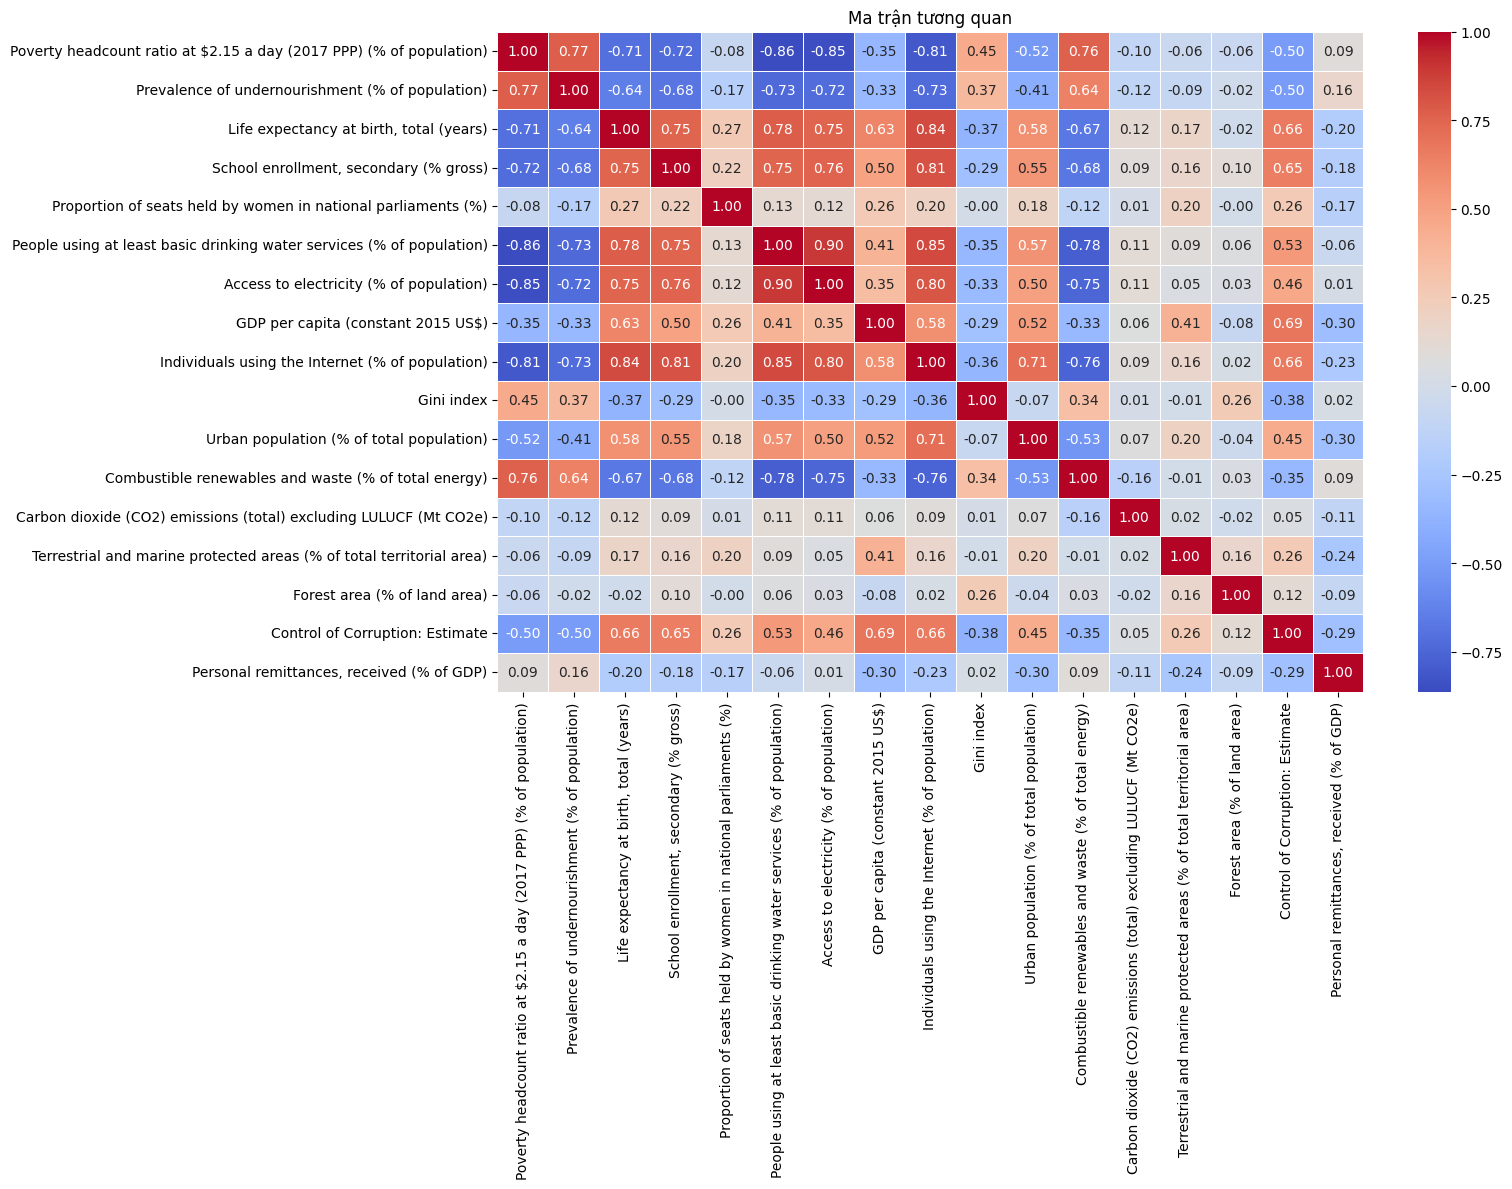

In [16]:
plt.figure(figsize=(16, 12))
numeric_df = df_imputed.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan')
plt.tight_layout()

Text(0, 0.5, 'Tuổi thọ')

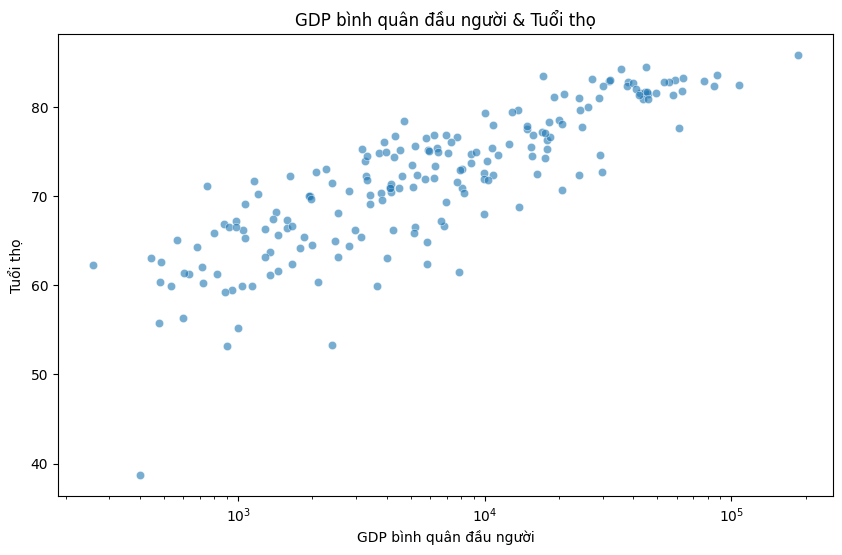

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_imputed, x='GDP per capita (constant 2015 US$)', y='Life expectancy at birth, total (years)', alpha=0.6)
plt.xscale('log')
plt.title('GDP bình quân đầu người & Tuổi thọ')
plt.xlabel('GDP bình quân đầu người')
plt.ylabel('Tuổi thọ')

Text(0.5, 1.0, 'Phân bố tuổi thọ')

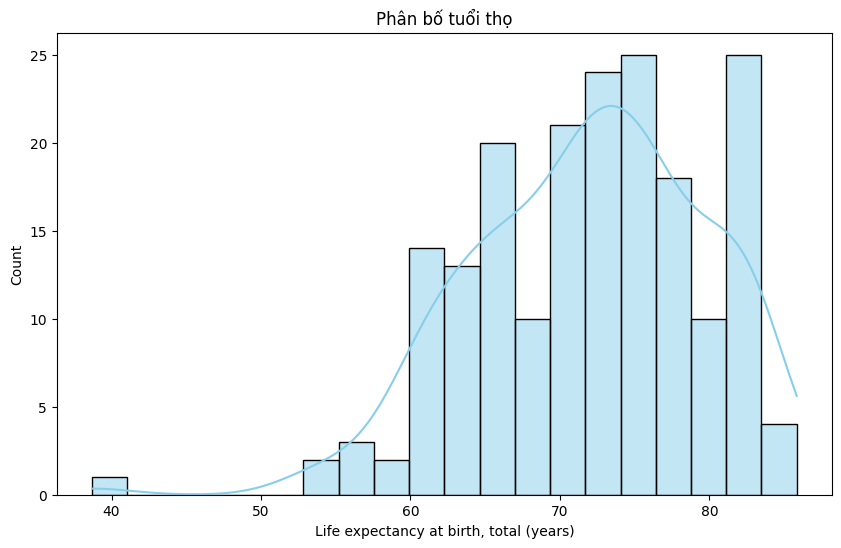

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df_imputed['Life expectancy at birth, total (years)'], bins=20, kde=True, color='skyblue')
plt.title('Phân bố tuổi thọ')

/tmp/ipython-input-658934698.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gdp, x='GDP per capita (constant 2015 US$)', y='REF_AREA_LABEL', palette='viridis')


Text(0, 0.5, 'Nước')

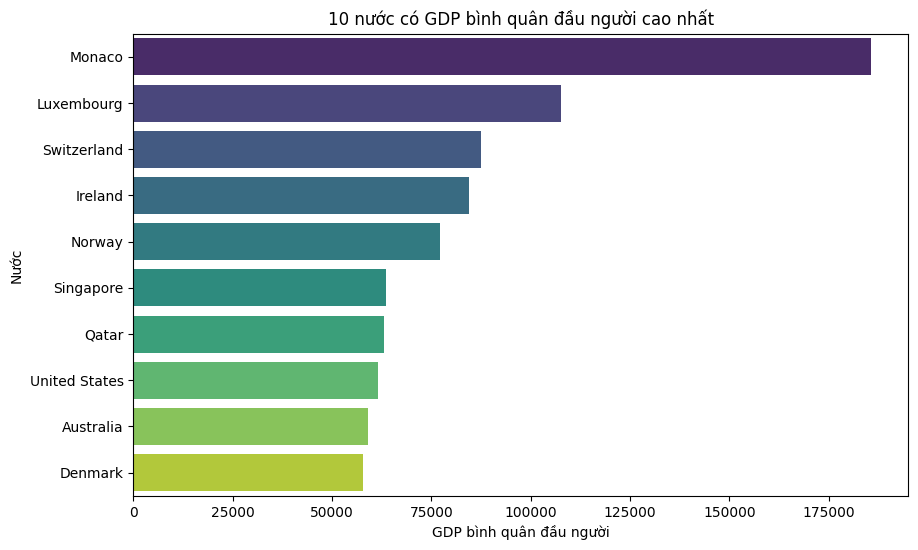

In [19]:
top_gdp = df_imputed.nlargest(10, 'GDP per capita (constant 2015 US$)')[['REF_AREA_LABEL', 'GDP per capita (constant 2015 US$)']]
plt.figure(figsize=(10, 6))
sns.barplot(data=top_gdp, x='GDP per capita (constant 2015 US$)', y='REF_AREA_LABEL', palette='viridis')
plt.title('10 nước có GDP bình quân đầu người cao nhất')
plt.xlabel('GDP bình quân đầu người')
plt.ylabel('Nước')

Text(0, 0.5, 'Kiểm soát tham nhũng')

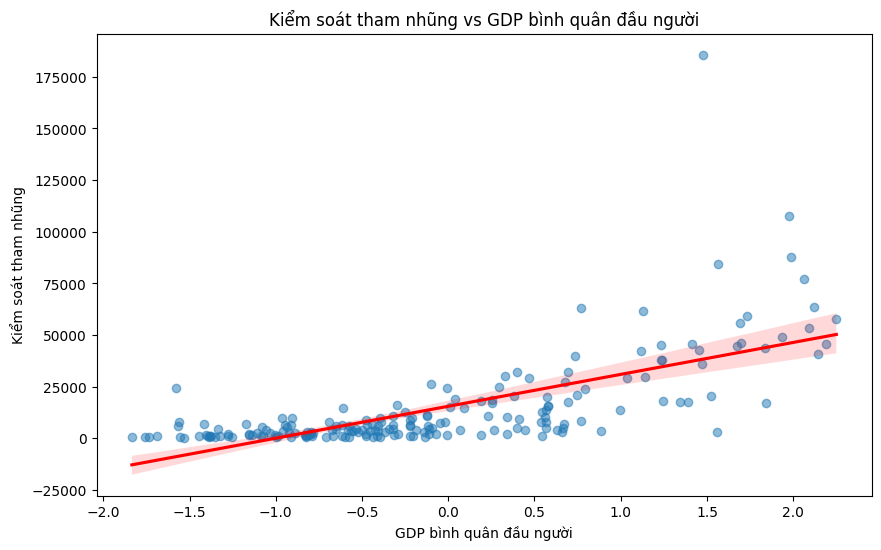

In [20]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_imputed, x='Control of Corruption: Estimate', y='GDP per capita (constant 2015 US$)', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Kiểm soát tham nhũng vs GDP bình quân đầu người')
plt.xlabel('GDP bình quân đầu người')
plt.ylabel('Kiểm soát tham nhũng')

Text(0, 0.5, 'Tỷ lệ nghèo đói')

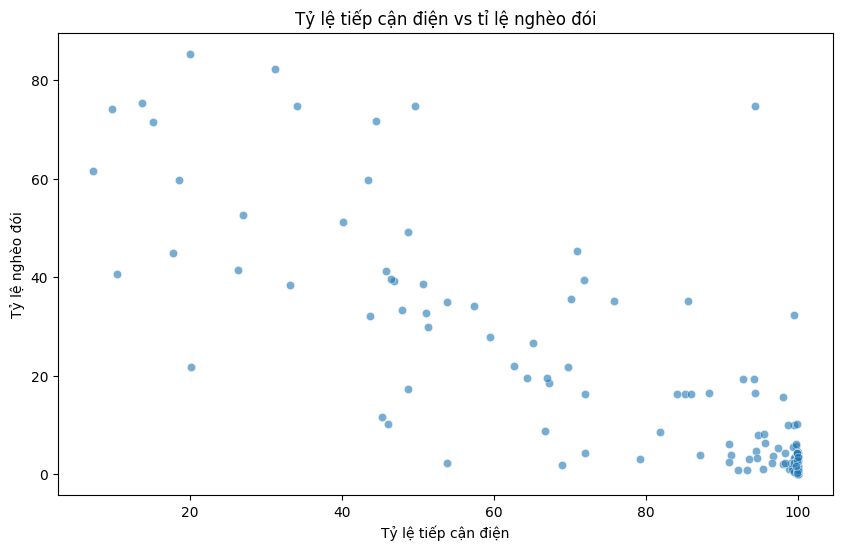

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_imputed, x='Access to electricity (% of population)', y='Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)', alpha=0.6)
plt.title('Tỷ lệ tiếp cận điện vs tỉ lệ nghèo đói')
plt.xlabel('Tỷ lệ tiếp cận điện')
plt.ylabel('Tỷ lệ nghèo đói')

In [22]:
life_exp_corr = corr['Life expectancy at birth, total (years)'].sort_values(ascending=False)
print("\n--- Correlation with Life Expectancy ---")
print(life_exp_corr)


--- Correlation with Life Expectancy ---
Life expectancy at birth, total (years)                                  1.000000
Individuals using the Internet (% of population)                         0.839416
People using at least basic drinking water services (% of population)    0.775567
Access to electricity (% of population)                                  0.752002
School enrollment, secondary (% gross)                                   0.746353
Control of Corruption: Estimate                                          0.661252
GDP per capita (constant 2015 US$)                                       0.627416
Urban population (% of total population)                                 0.576775
Proportion of seats held by women in national parliaments (%)            0.271544
Terrestrial and marine protected areas (% of total territorial area)     0.174085
Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)        0.120508
Forest area (% of land area)                            

**Các nhóm chỉ số chính:**
1. Kinh tế: GDP per capita, Gini index, Nghèo đói ($2.15/ngày).
2. Hạ tầng & Công nghệ: Tiếp cận điện, nước sạch, sử dụng Internet.
3. Xã hội & Sức khỏe: Kỳ vọng sống, tỷ lệ suy dinh dưỡng, giáo dục.
4. Môi trường: Diện tích rừng, năng lượng tái tạo, khu bảo tồn.
5. Quản trị: Kiểm soát tham nhũng, tỷ lệ phụ nữ trong quốc hội.

**Ma trận tương quan (Correlation)**
Dựa trên bản đồ nhiệt (Heatmap), chúng ta thấy một số mối quan hệ rất mạnh:'

1. Kỳ vọng sống (Life Expectancy) có mối tương quan
thuận rất cao với:
* Tỷ lệ sử dụng Internet ($0.84$)
* Dịch vụ nước sạch ($0.78$)
* Tiếp cận điện năng ($0.75$)

2. Kỳ vọng sống có tương quan nghịch mạnh với:
- Tỷ lệ nghèo đói ($-0.71$)
- Năng lượng từ chất thải và nhiên liệu đốt ($-0.66$) - thường thấy ở các nước đang phát triển phụ thuộc vào củi/than.

**Phân tích chi tiết các chỉ số chính**
1. GDP bình quân đầu người và Kỳ vọng sống
- Biểu đồ phân tán (Scatter Plot) cho thấy mối quan hệ phi tuyến tính rõ rệt. Khi GDP tăng, tuổi thọ tăng nhanh ở giai đoạn đầu nhưng sẽ chững lại khi đạt đến ngưỡng thu nhập cao.
- Nhóm quốc gia có GDP đầu người cao nhất (Top 10) bao gồm các nước như Monaco, Liechtenstein, Luxembourg, Bermuda, v.v.
2. Tình trạng nghèo đói và Hạ tầng
- Có sự tỷ lệ nghịch tuyệt đối giữa Tiếp cận điện năng và Tỷ lệ nghèo đói. Các quốc gia có tỷ lệ nghèo đói trên $40\%$ hầu hết đều có tỷ lệ tiếp cận điện rất thấp (dưới $60\%$).
3. Quản trị và Kinh tế
- Kiểm soát tham nhũng có mối tương quan thuận với GDP. Các quốc gia có chỉ số kiểm soát tham nhũng cao thường có nền kinh tế phát triển ổn định và thu nhập đầu người cao hơn.


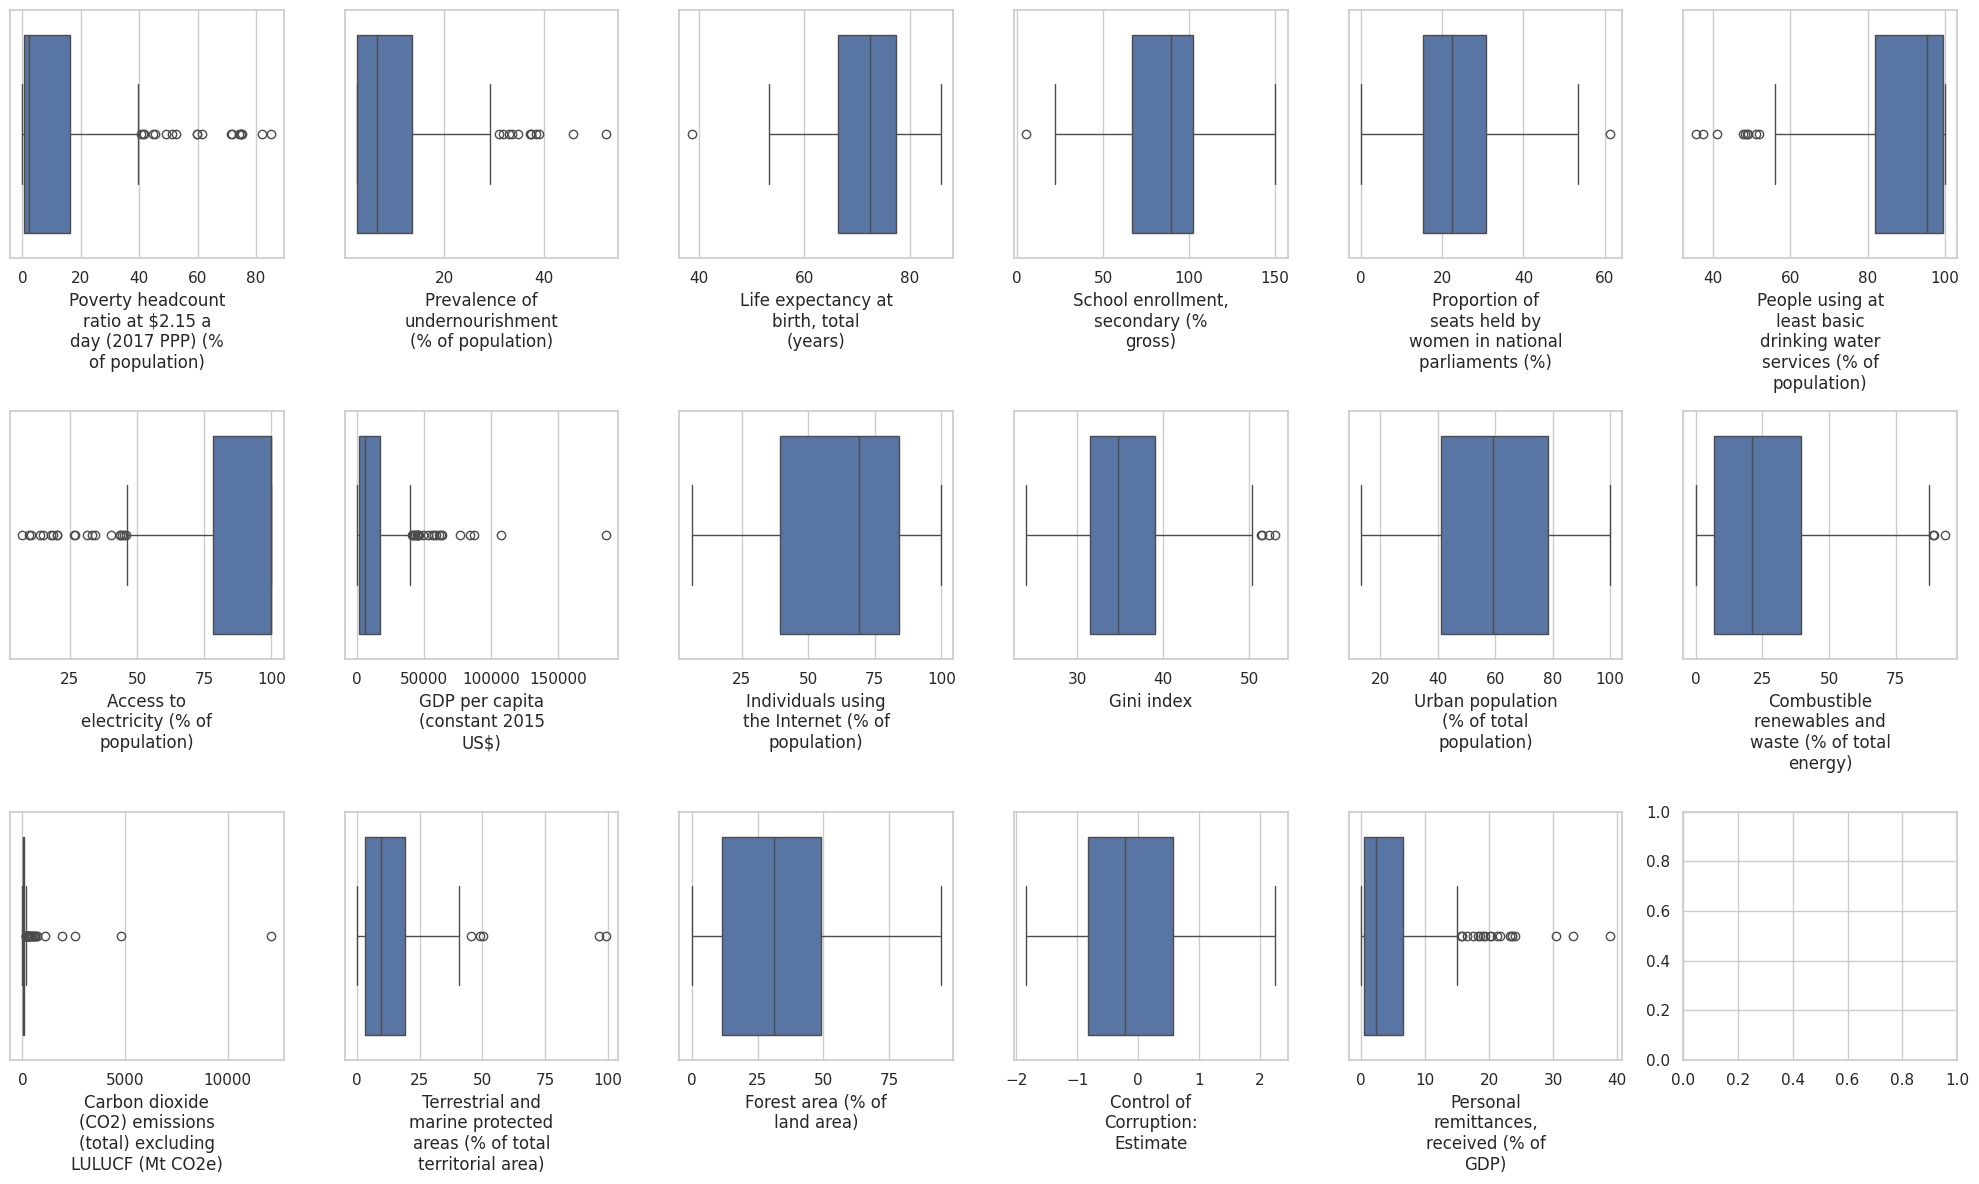

In [37]:
import textwrap

def wrap_label(text, width=20):
    return "\n".join(textwrap.wrap(text, width))

Indicators = df_imputed.columns[1:]

sns.set(style="whitegrid")
n_cols = 6
n_rows = (len(Indicators) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(Indicators):
    sns.boxplot(data=df_imputed, x=col, ax=axes[i])

    wrapped = wrap_label(col, width=18)
    axes[i].set_xlabel(wrapped)

plt.tight_layout()
plt.show()


- Chỉ số "Công việc và tăng trưởng kinh tế" và "Hành động về khí hậu" cần được chuẩn hóa lại để mô hình có thể hoạt động tốt hơn.

# Chuẩn hóa

In [24]:
scaler = StandardScaler()

data_to_scale = df_imputed.drop(columns=['REF_AREA_LABEL'])

data_scaler = scaler.fit_transform(data_to_scale)

df_scaled = pd.DataFrame(data_scaler, columns=data_to_scale.columns, index=df_imputed.index)
df_scaled.insert(0, 'REF_AREA_LABEL', df_imputed['REF_AREA_LABEL'])
df_scaled.head()

,REF_AREA_LABEL,Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Prevalence of undernourishment (% of population),"Life expectancy at birth, total (years)","School enrollment, secondary (% gross)",Proportion of seats held by women in national parliaments (%),People using at least basic drinking water services (% of population),Access to electricity (% of population),GDP per capita (constant 2015 US$),Individuals using the Internet (% of population),Gini index,Urban population (% of total population),Combustible renewables and waste (% of total energy),Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e),Terrestrial and marine protected areas (% of total territorial area),Forest area (% of land area),Control of Corruption: Estimate,"Personal remittances, received (% of GDP)"
0,Afghanistan,3.101887,1.692999,-1.207976,-1.031936,0.298259,-0.756295,0.366945,-0.627481,-1.722420,1.157423,-1.439358,1.812756,-0.187983,-0.793040,-1.255254,-1.298666,-0.209583
3,Albania,-0.594850,-0.605290,0.845678,0.490254,0.658940,0.432539,0.594940,-0.438772,0.420862,-0.973000,0.121602,-0.614748,-0.190872,0.044556,-0.138510,-0.474668,0.665474
4,Algeria,-0.553298,-0.791583,0.423108,0.796163,-0.413381,0.400840,0.583621,-0.445559,0.020985,-0.752544,0.625306,-1.099049,-0.010710,-0.561395,-1.298139,-0.593092,-0.576342
6,Andorra,-0.601002,-0.055321,1.414675,0.440131,1.644266,0.765803,0.594940,1.049588,1.157568,-0.766686,1.240663,-0.184442,0.129233,0.942889,0.079148,1.309605,-0.560886
7,Angola,1.333522,0.970101,-1.127120,-1.200022,0.581746,-2.026786,-1.550794,-0.536062,-1.009760,2.693655,0.326259,0.913665,-0.169614,-0.595294,0.882714,-0.834321,-0.711598


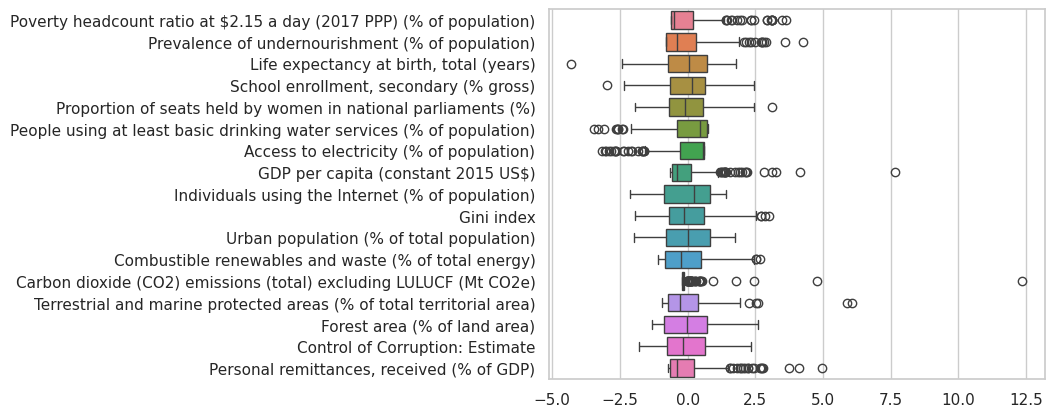

In [25]:
sns.boxplot(data=df_scaled, orient='h')
plt.show()

# PCA

In [26]:
pca = PCA(n_components=17)
pca.fit(df_scaled.drop(columns=['REF_AREA_LABEL']))

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

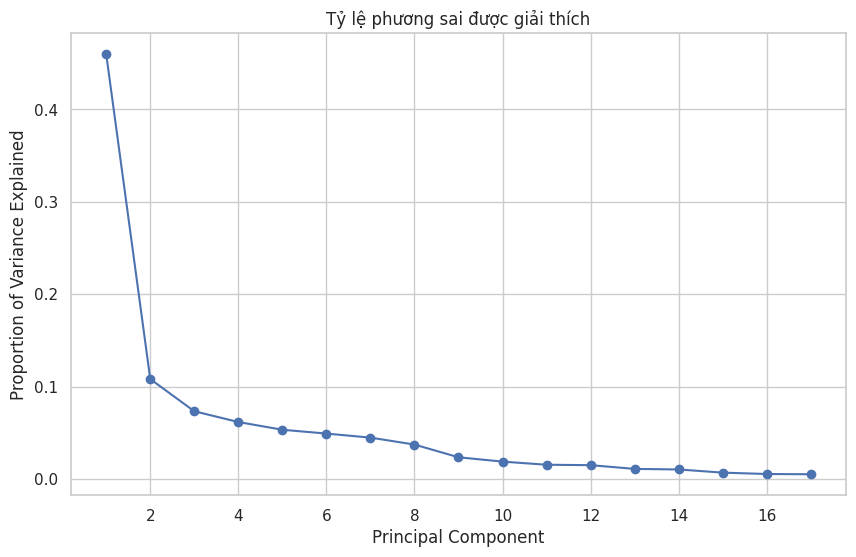

In [27]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(prop_var)+1), prop_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Tỷ lệ phương sai được giải thích')
plt.grid(True)
plt.show()

In [28]:
print(sum(prop_var[0:3]))

0.6411835671332945


PC1 và PC2 giải thích được khoảng 46% và 10% phương sai, trong khi các thàn phần còn lại giải thích được rất ít. Vậy nên hai thành phần đầu tiên nên được giữ lại.

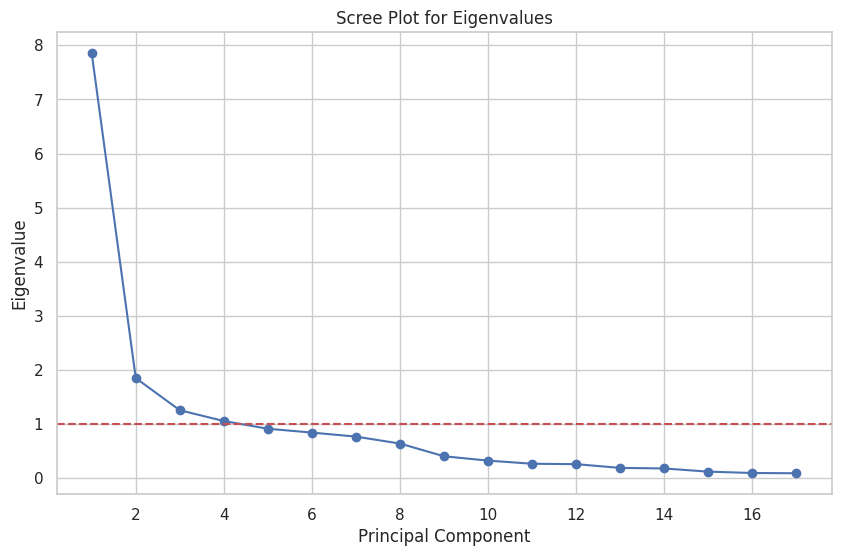

In [29]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot for Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [30]:
pca = PCA(n_components=3)
coords = pca.fit_transform(df_scaled.drop(columns=['REF_AREA_LABEL']))

PC_columns = [f"PC{i+1}" for i in range(pca.n_components)]

df_pca = pd.DataFrame(coords, columns=PC_columns, index=df_scaled.index)
df_pca.head(10)

,PC1,PC2,PC3
0,-4.440609,0.199704,-0.681927
3,1.384765,-1.001156,-0.291110
4,1.394803,-1.304758,-0.833515
6,2.933966,1.703989,-0.540343
7,-3.776741,1.589128,1.606514
8,1.016093,-1.187262,-0.579607
10,1.821779,0.321704,0.258828
11,1.539103,-1.052494,-0.788768
13,4.045589,1.821430,-0.727018
14,2.942229,1.595972,-0.277547


In [31]:
df_pca.shape

(192, 3)

In [32]:
# @title Thêm cột mã quốc gia
country_iso_map = {
    "Afghanistan": "AFG", "Albania": "ALB", "Algeria": "DZA", "Andorra": "AND", "Angola": "AGO",
    "Antigua and Barbuda": "ATG", "Argentina": "ARG", "Armenia": "ARM", "Australia": "AUS", "Austria": "AUT",
    "Azerbaijan": "AZE", "Bahamas, The": "BHS", "Bahrain": "BHR", "Bangladesh": "BGD", "Barbados": "BRB",
    "Belarus": "BLR", "Belgium": "BEL", "Belize": "BLZ", "Benin": "BEN", "Bhutan": "BTN",
    "Bolivia": "BOL", "Bosnia and Herzegovina": "BIH", "Botswana": "BWA", "Brazil": "BRA", "Brunei Darussalam": "BRN",
    "Bulgaria": "BGR", "Burkina Faso": "BFA", "Burundi": "BDI", "Cabo Verde": "CPV", "Cambodia": "KHM",
    "Cameroon": "CMR", "Canada": "CAN", "Central African Republic": "CAF", "Chad": "TCD", "Chile": "CHL",
    "China": "CHN", "Colombia": "COL", "Comoros": "COM", "Congo, Dem. Rep.": "COD", "Congo, Rep.": "COG",
    "Costa Rica": "CRI", "Cote d'Ivoire": "CIV", "Croatia": "HRV", "Cuba": "CUB", "Cyprus": "CYP",
    "Czechia": "CZE", "Denmark": "DNK", "Djibouti": "DJI", "Dominica": "DMA", "Dominican Republic": "DOM",
    "Ecuador": "ECU", "Egypt, Arab Rep.": "EGY", "El Salvador": "SLV", "Equatorial Guinea": "GNQ", "Eritrea": "ERI",
    "Estonia": "EST", "Eswatini": "SWZ", "Ethiopia": "ETH", "Fiji": "FJI", "Finland": "FIN",
    "France": "FRA", "Gabon": "GAB", "Gambia, The": "GMB", "Georgia": "GEO", "Germany": "DEU",
    "Ghana": "GHA", "Greece": "GRC", "Grenada": "GRD", "Guatemala": "GTM", "Guinea": "GIN",
    "Guinea-Bissau": "GNB", "Guyana": "GUY", "Haiti": "HTI", "Honduras": "HND", "Hungary": "HUN",
    "Iceland": "ISL", "India": "IND", "Indonesia": "IDN", "Iran, Islamic Rep.": "IRN", "Iraq": "IRQ",
    "Ireland": "IRL", "Israel": "ISR", "Italy": "ITA", "Jamaica": "JAM", "Japan": "JPN",
    "Jordan": "JOR", "Kazakhstan": "KAZ", "Kenya": "KEN", "Kiribati": "KIR", "Korea, Dem. People’s Rep.": "PRK",
    "Korea, Rep.": "KOR", "Kuwait": "KWT", "Kyrgyz Republic": "KGZ", "Lao PDR": "LAO", "Latvia": "LVA",
    "Lebanon": "LBN", "Lesotho": "LSO", "Liberia": "LBR", "Libya": "LBY", "Liechtenstein": "LIE",
    "Lithuania": "LTU", "Luxembourg": "LUX", "Madagascar": "MDG", "Malawi": "MWI", "Malaysia": "MYS",
    "Maldives": "MDV", "Mali": "MLI", "Malta": "MLT", "Marshall Islands": "MHL", "Mauritania": "MRT",
    "Mauritius": "MUS", "Mexico": "MEX", "Micronesia, Fed. Sts.": "FSM", "Moldova": "MDA", "Monaco": "MCO",
    "Mongolia": "MNG", "Montenegro": "MNE", "Morocco": "MAR", "Mozambique": "MOZ", "Myanmar": "MMR",
    "Namibia": "NAM", "Nauru": "NRU", "Nepal": "NPL", "Netherlands": "NLD", "New Zealand": "NZL",
    "Nicaragua": "NIC", "Niger": "NER", "Nigeria": "NGA", "North Macedonia": "MKD", "Norway": "NOR",
    "Oman": "OMN", "Pakistan": "PAK", "Palau": "PLW", "Panama": "PAN", "Papua New Guinea": "PNG",
    "Paraguay": "PRY", "Peru": "PER", "Philippines": "PHL", "Poland": "POL", "Portugal": "PRT",
    "Qatar": "QAT", "Romania": "ROU", "Russian Federation": "RUS", "Rwanda": "RWA", "Samoa": "WSM",
    "San Marino": "SMR", "Sao Tome and Principe": "STP", "Saudi Arabia": "SAU", "Senegal": "SEN", "Serbia": "SRB",
    "Seychelles": "SYC", "Sierra Leone": "SLE", "Singapore": "SGP", "Slovak Republic": "SVK", "Slovenia": "SVN",
    "Solomon Islands": "SLB", "Somalia": "SOM", "South Africa": "ZAF", "South Sudan": "SSD", "Spain": "ESP",
    "Sri Lanka": "LKA", "St. Kitts and Nevis": "KNA", "St. Lucia": "LCA", "St. Vincent and the Grenadines": "VCT",
    "Sudan": "SDN", "Suriname": "SUR", "Sweden": "SWE", "Switzerland": "CHE", "Syrian Arab Republic": "SYR",
    "Tajikistan": "TJK", "Tanzania": "TZA", "Thailand": "THA", "Timor-Leste": "TLS", "Togo": "TGO",
    "Tonga": "TON", "Trinidad and Tobago": "TTO", "Tunisia": "TUN", "Turkey": "TUR", "Turkmenistan": "TKM",
    "Tuvalu": "TUV", "Uganda": "UGA", "Ukraine": "UKR", "United Arab Emirates": "ARE", "United Kingdom": "GBR",
    "United States": "USA", "Uruguay": "URY", "Uzbekistan": "UZB", "Vanuatu": "VUT", "Venezuela, RB": "VEN",
    "Viet Nam": "VNM", "West Bank and Gaza": "PSE", "Yemen, Rep.": "YEM", "Zambia": "ZMB", "Zimbabwe": "ZWE"
}

In [33]:
df_pca['REF_AREA_LABEL'] = country
df_pca = df_pca[['REF_AREA_LABEL'] + PC_columns]
df_pca = df_pca.reset_index(drop=True)

df_pca['ISO'] = df_pca['REF_AREA_LABEL'].map(country_iso_map)
df_pca = df_pca[['REF_AREA_LABEL', 'ISO'] + PC_columns]
df_pca.columns = ['Country', 'Country_code',] + PC_columns
df_pca.head()

,Country,Country_code,PC1,PC2,PC3
0,Afghanistan,AFG,-4.440609,0.199704,-0.681927
1,Albania,ALB,1.384765,-1.001156,-0.291110
2,Algeria,DZA,1.394803,-1.304758,-0.833515
3,Andorra,AND,2.933966,1.703989,-0.540343
4,Angola,AGO,-3.776741,1.589128,1.606514


In [34]:
# df_pca.to_csv('/content/drive/MyDrive/IE313/DoAn/Data/wdi_pca_3.csv', index=False)